In [2]:
import pandas as pd
from pathlib import Path
import os
from numpy import *

In [3]:
from tensorflow import keras

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

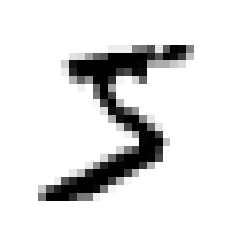

In [6]:
some_digit = X_train[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')   #imshow()热力图函数负责对图像进行处理，并显示其格式
plt.axis('off')
plt.show()

In [7]:
y_train[0]

5

In [8]:
#训练二元分类器

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)
X_train_2D = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])  #将三维数组转换为二维数组
sgd_clf.fit(X_train_2D,y_train_5)

SGDClassifier(random_state=42)

In [12]:
some_digit = X_train_2D[0]
sgd_clf.predict([some_digit])

array([ True])

In [13]:
#分类器的性能测量：交叉验证、混淆矩阵、精度和召回率、ROC曲线

In [14]:
#交叉验证，K折验证，留1个折叠用于预测准确性

In [15]:
from sklearn.model_selection import StratifiedKFold      #分层抽样
from sklearn.base import clone

In [16]:
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train_2D,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train_2D[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_folds = X_train_2D[test_index]
    y_test_folds = y_train_5[test_index]    
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))
    

0.95035
0.96035
0.9604


In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
cross_val_score(sgd_clf,X_train_2D,y_train_5,cv=3,scoring='accuracy') #样本存在偏数据

array([0.95035, 0.96035, 0.9604 ])

In [31]:
from sklearn.base import BaseEstimator

In [20]:
class Never5Classifier(BaseEstimator):               #产生随机结果的分类器作为对比
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return zeros((len(X),1),dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train_2D,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [26]:
#采用混淆矩阵，解决偏数据评估问题

In [48]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_2D, y_train_5, cv=3)

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [50]:
#(精度和召回率），精度为列，召回率为行

In [51]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [52]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [53]:
#F1分数，会给予低值更高的权重

In [54]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [32]:
#精度和召回率的权衡,通过阈值可以调整

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train_2D, y_train_5, cv=3, method='decision_function')
from sklearn.metrics import precision_recall_curve
precisons,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)                     #精度和召回率的阈值函数

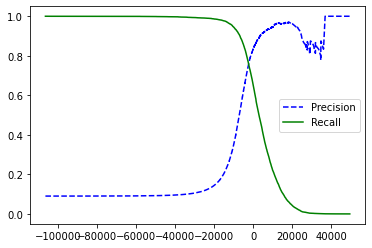

In [39]:
def plot_precision_recall_vs_threshold(precisions,recalls, thresholds):
    plt.plot(thresholds,precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds,recalls[:-1], 'g-', label = 'Recall')
plot_precision_recall_vs_threshold(precisons,recalls,thresholds)
plt.legend()
plt.show()

In [42]:
#寻找精度大于等于90%的阈值
threshold_90_precision = thresholds[argmax(precisons >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [47]:
#ROC曲线（真正类率和假正类率），也可以说是灵敏度（召回率）和（1-特异度）的关系

In [49]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)                      #真正类率和假正类率的阈值函数

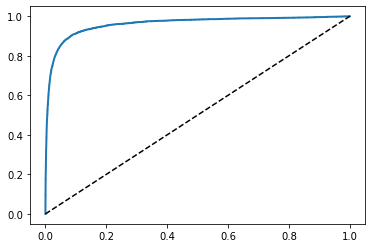

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')                          #虚线表示纯随机分类器的ROC曲线，离开这条线越远越好
    
plot_roc_curve(fpr, tpr)
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [53]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_2D, y_train_5, cv=3, method='predict_proba')

In [54]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

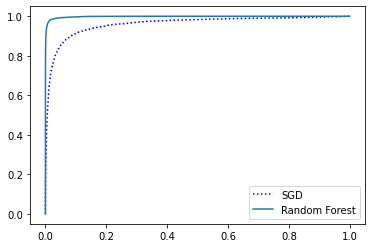

In [56]:
plt.plot(fpr,tpr,'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label = 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [60]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [1]:
#多分类器。实现方法：1对剩余策略，每个分类训练一个二元分类器；1对1策略，每对类别训练一个二元分类器，共N*N-1/2个分类器

In [17]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train_2D, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [18]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


In [19]:
argmax(some_digit_scores)

5

In [20]:
##使用1对1策略

In [21]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train_2D, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [22]:
len(ovr_clf.estimators_)

10

In [32]:
cross_val_score(sgd_clf, X_train_2D, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [33]:
##对输入进行标准化缩放
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2D.astype(float64))

In [34]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [35]:
#误差分析

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

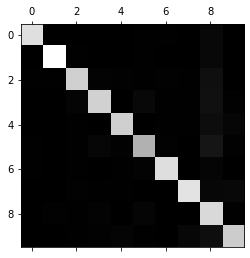

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

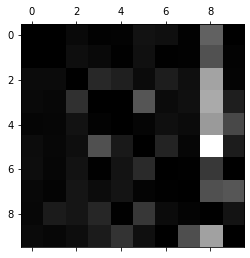

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

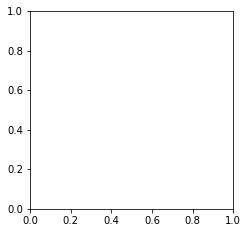

In [43]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)

In [40]:
#多标签分类，输出一个数组，比如[1,0,1]

In [41]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_2D, y_multilabel)

KNeighborsClassifier()

In [42]:
knn_clf.predict([some_digit])    #多标签分类输出

array([[False,  True]])

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_2D, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605